In [1]:
import os
import os.path as osp
import argparse
import copy

import math
import numpy as np
from PIL import Image
import cv2
from plyfile import PlyData
import json

from utils.json_to_landmark.pyutils import _kps1d_to_2d, getImageRatio, _kps_downscale, get_proj_depth, get_distance
from utils.json_to_landmark.size_info import getSizingPts

In [2]:
''' hyper-params '''
deg = 0.275

In [3]:
root = 'samples/point_cloud_sample1'

In [4]:
print('root :',root)

''' File Load '''
predicted_json_file = osp.join(root, 'estimated_kpt.json')
print('predicted_json_file : ',predicted_json_file)
with open(predicted_json_file, 'r') as f:
    predicted_json = json.load(f)

img_path = f'{root}/rgb.jpg'
ply_path = f'{root}/ply.ply'
print('img_path :',img_path)
print('ply_path :',ply_path)

image = Image.open(img_path) 
ply = PlyData.read(ply_path) 
print('image size :',image.size)
''' '''

''' json to Landmark position & length(cm) calculation '''
measure_index, measure_points = getSizingPts(1) # 1: 반팔
w_r, h_r = getImageRatio(image, ply)

predicted = predicted_json[0]
pred_kpt1d = predicted['keypoints']
kps_arr = _kps1d_to_2d(pred_kpt1d)
kps_arr = _kps_downscale(kps_arr, (w_r, h_r)) 
kps_dict = {i+1: arr for i, arr in enumerate(kps_arr)}
ply_dpt = get_proj_depth(ply)  # projected depth array

result = {name:{'pt1':None, 'pt2':None, 'cm':None} for name in measure_index.values()}
for a, name in measure_index.items() : 
    pt1, pt2 = [tuple(kps_dict[pt_key].astype(int)) for pt_key in measure_points[a]]
    result[name]['depth_pt1'] = int(pt1[0]) , int(pt1[1])
    result[name]['depth_pt2'] = int(pt2[0]) , int(pt2[1])
    result[name]['pt1'] = int(pt1[0]*w_r), int(pt1[1]*h_r)
    result[name]['pt2'] = int(pt2[0]*w_r), int(pt2[1]*h_r)

    size_ = get_distance(pt1, pt2, ply_dpt, deg=deg)
    result[name]['cm'] = round(size_, 2)

root : samples/point_cloud_sample1
predicted_json_file :  samples/point_cloud_sample1/estimated_kpt.json
img_path : samples/point_cloud_sample1/rgb.jpg
ply_path : samples/point_cloud_sample1/ply.ply
image size : (1920, 1440)


In [5]:
result

{'Total-length': {'pt1': (945, 202),
  'pt2': (930, 1342),
  'cm': 60.44,
  'depth_pt1': (126, 27),
  'depth_pt2': (124, 179)},
 'Chest-size': {'pt1': (630, 630),
  'pt2': (1230, 645),
  'cm': 33.19,
  'depth_pt1': (84, 84),
  'depth_pt2': (164, 86)},
 'Waist-length': {'pt1': (585, 1260),
  'pt2': (1282, 1245),
  'cm': 42.28,
  'depth_pt1': (78, 168),
  'depth_pt2': (171, 166)},
 'Arm-width': {'pt1': (442, 615),
  'pt2': (630, 705),
  'cm': 16.41,
  'depth_pt1': (59, 82),
  'depth_pt2': (84, 94)}}

In [24]:
img_arr = np.asarray(image)
for r in result : 
    pt1, pt2 = result[r]['pt1'] , result[r]['pt2']
    cm = result[r]['cm']

    for c in [pt1, pt2] :
        cv2.circle(img_arr,
                c,
                5,
                (255,0,0),
                thickness=-1
              )
    cv2.line(img_arr,
        pt1,
        pt2,
        (255,0,0), 
        thickness=2, 
        lineType=cv2.LINE_AA)
    cv2.putText(img_arr, r, (pt2[0]-100,pt2[1]+40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
    if r == 'Waist-length' :
         cv2.putText(img_arr, f'({cm}cm)', (pt2[0]+110,pt2[1]+40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
    elif r == 'Total-length' :
        cv2.putText(img_arr, f'({cm}cm)', (pt2[0]+100,pt2[1]+40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
    else :
        cv2.putText(img_arr, f'({cm}cm)', (pt2[0]-100,pt2[1]+80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)

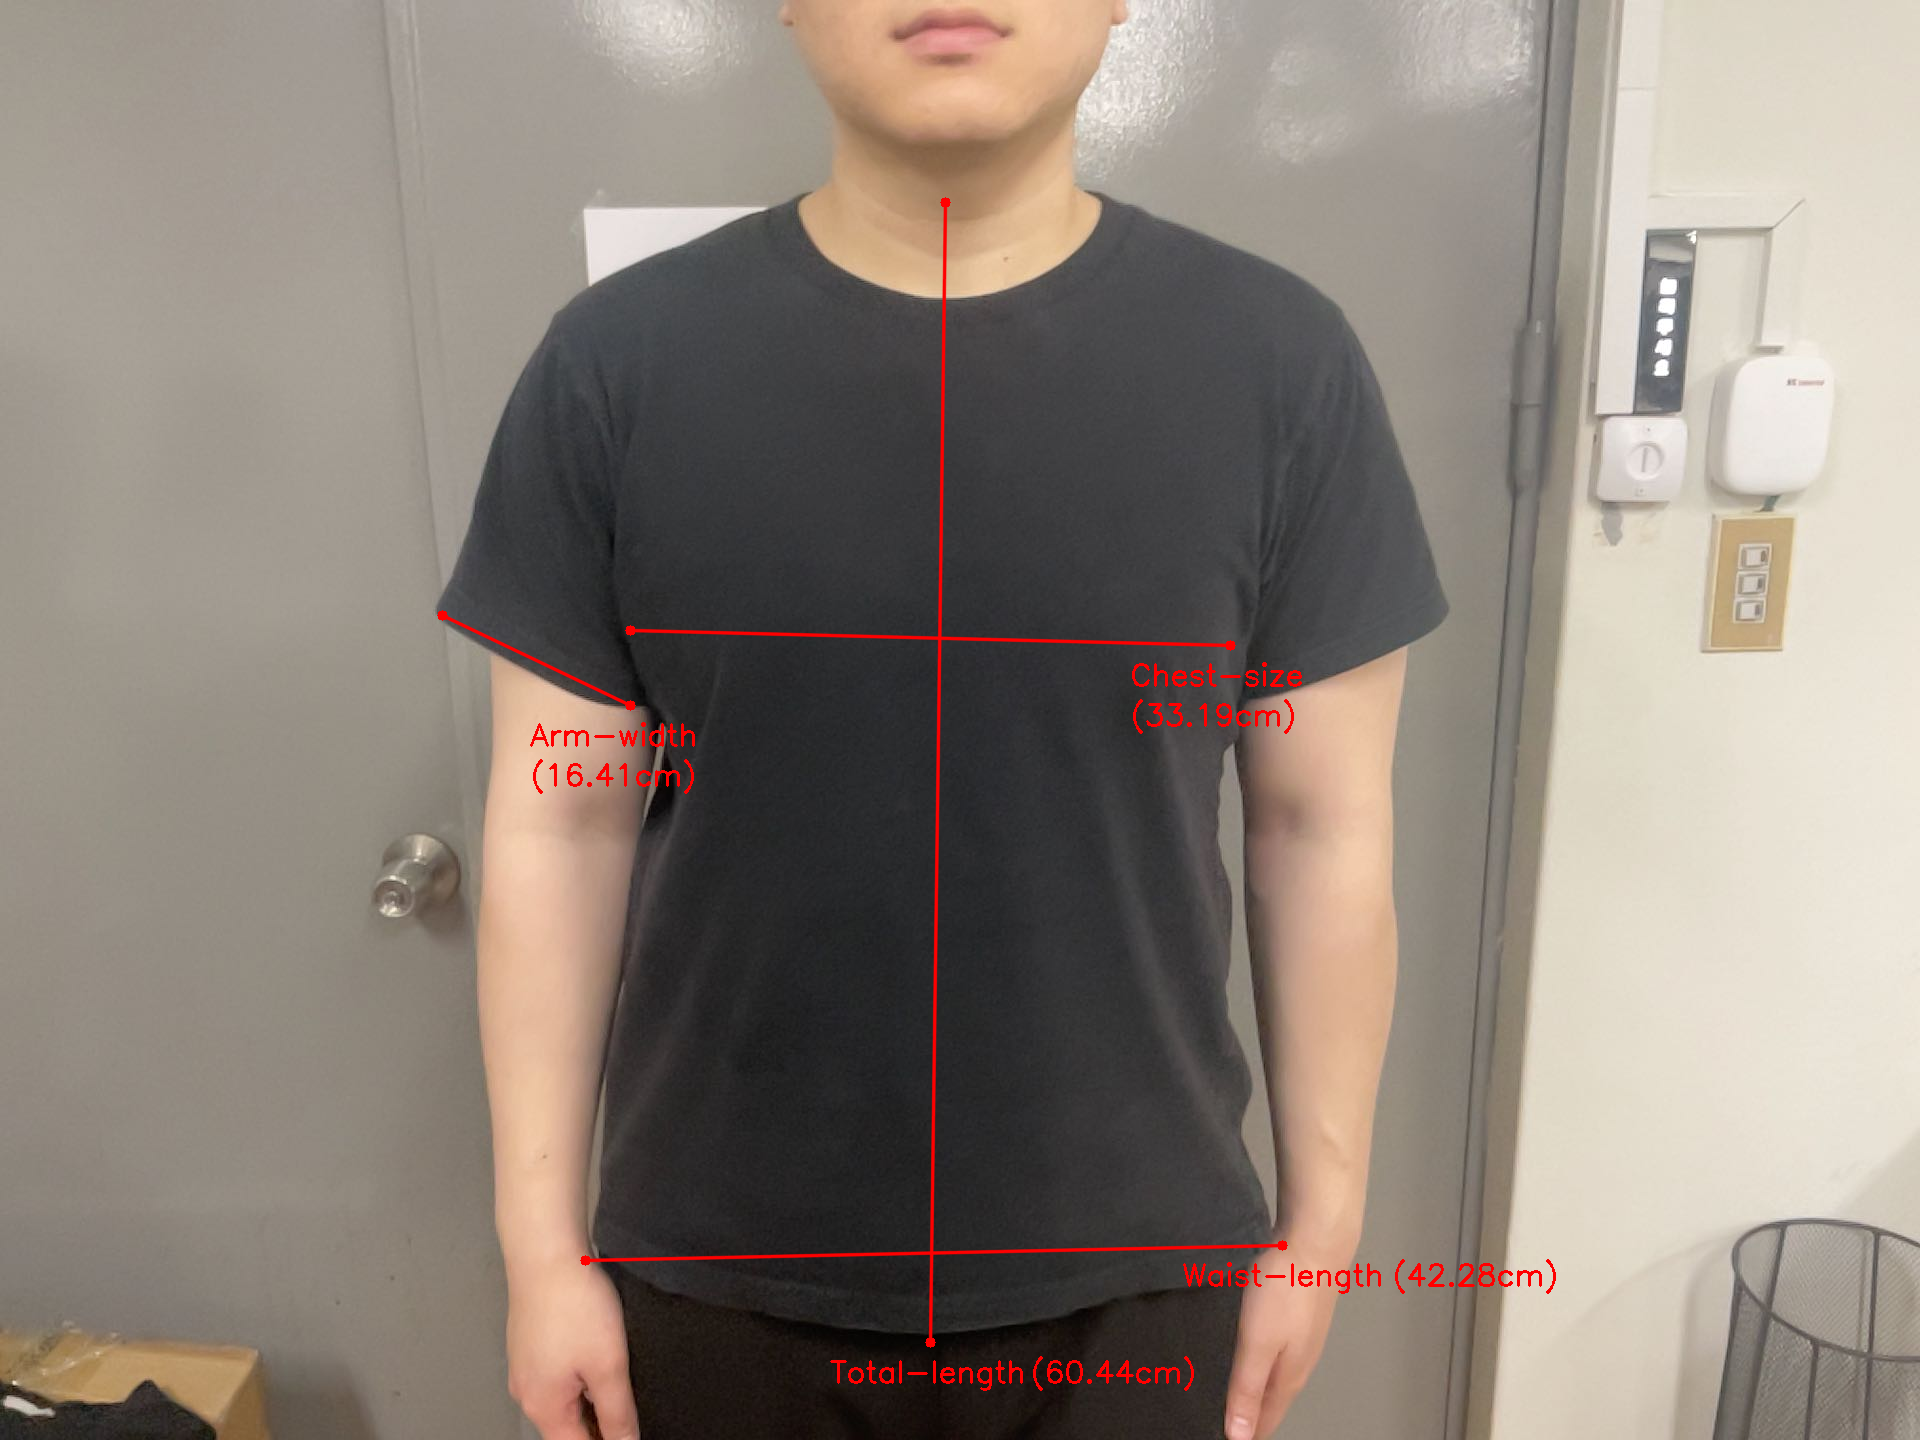

In [25]:
result_img = Image.fromarray(img_arr)
result_img